
The SEM dataset is composed of a training and a validation images acquired on a scanning 
electron microscopy (SEM). They were originally used in Buchholtz et al (2019) to showcase
CARE denoising. Here, we demonstrate the performances of N2V2, an extension of Noise2Void,
on this particular dataset!

In [1]:
# Imports necessary to execute the code
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tifffile
from careamics import CAREamist
from careamics.config import create_n2v_configuration
from careamics_portfolio import PortfolioManager
from PIL import Image

## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

In [2]:
# instantiate data portfolio manage
portfolio = PortfolioManager()

# and download the data
root_path = Path("./data")
files = portfolio.denoising.N2V_SEM.download(root_path)

## Visualize data

Text(0.5, 1.0, 'Validation Image')

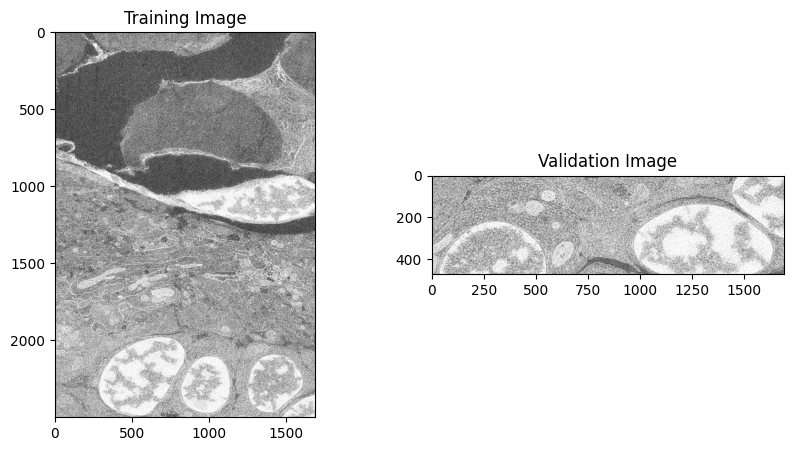

In [3]:
# load training and validation image and show them side by side
train_image = tifffile.imread(files[0])
val_image = tifffile.imread(files[1])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_image, cmap="gray")
ax[0].set_title("Training Image")
ax[1].imshow(val_image, cmap="gray")
ax[1].set_title("Validation Image")

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the various
parameters available in CAREamics. However, a straightforward way to create a configuration
for a particular algorithm is to use one of the convenience functions.

There the switch between Noise2Void and N2V2 is done by changing the `use_n2v2` parameter.

In [4]:
config = create_n2v_configuration(
    experiment_name="sem_n2v",
    data_type="array",
    axes="YX",
    patch_size=(64, 64),
    batch_size=32,
    num_epochs=30,
    use_n2v2=True,
)

print(config)

{'algorithm_config': {'algorithm': 'n2v',
                      'loss': 'n2v',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': True,
                                'n2v2': True,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'YX',
                 'batch_size': 32,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'transforms': [{'flip_x': True,
      

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [5]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_image,
    val_source=val_image,
)

No working directory provided. Using current working directory: /home/melisande.croft/Documents/Repos/careamics-examples/applications/n2v/2D.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA A40-8Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Computed dataset mean: [39216.047], std: [18678.184]
/localscratch/miniforge3/envs/careamics/

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 29: 100%|██████████| 34/34 [00:01<00:00, 21.04it/s, train_loss_step=0.571, val_loss=0.542, train_loss_epoch=0.602]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 34/34 [00:01<00:00, 19.33it/s, train_loss_step=0.571, val_loss=0.542, train_loss_epoch=0.602]


## Predict with CAREamics

Prediction is done with the same `CAREamist` used for training. Because the image is large
we predict using tiling.

In [6]:
prediction = careamist.predict(source=train_image, tile_size=(256, 256))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

### Visualize the prediction

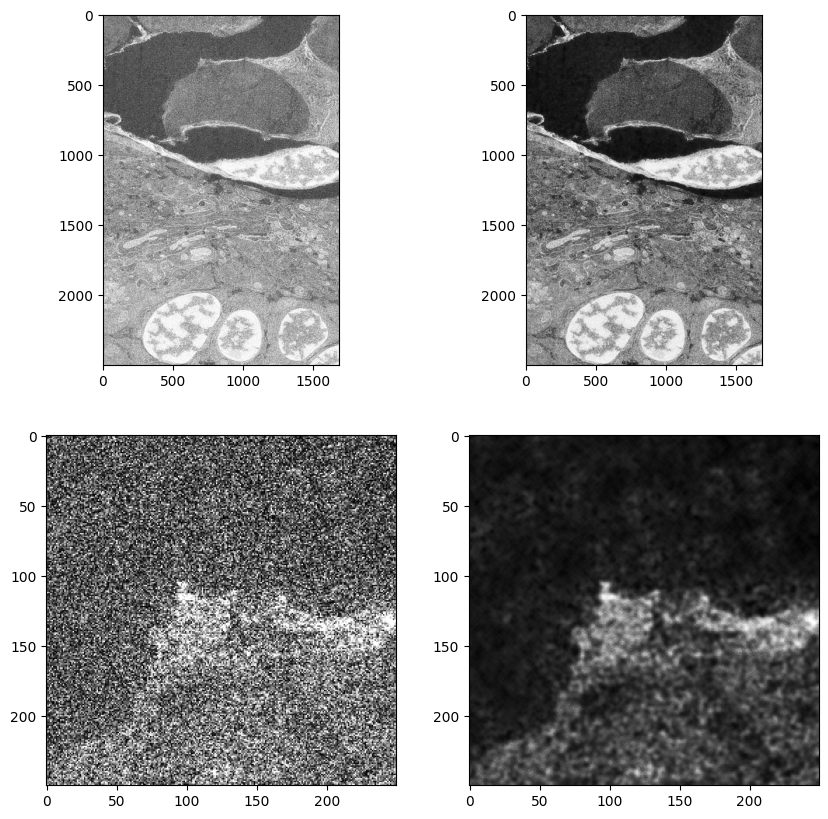

In [7]:
# Show the full image and crops
x_start, x_end = 600, 850
y_start, y_end = 200, 450

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(train_image, cmap="gray")
ax[0, 1].imshow(prediction[0].squeeze(), cmap="gray")
ax[1, 0].imshow(train_image[y_start:y_end, x_start:x_end], cmap="gray")
ax[1, 1].imshow(prediction[0].squeeze()[y_start:y_end, x_start:x_end], cmap="gray")

## Export the model

The model is automatically saved during training (the so-called `checkpoints`) and can 
be loaded back easily, but you can also export the model to the [BioImage Model Zoo](www.bioimage.io)
format.

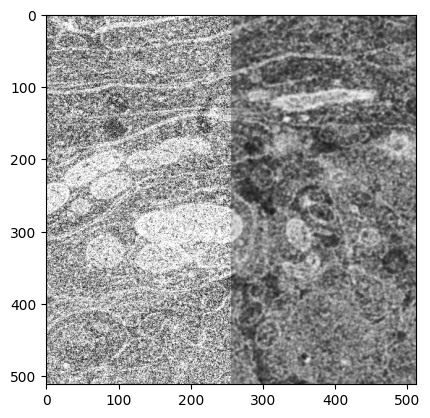

In [8]:
# create a cover image
x_start, width = 500, 512
y_start, height = 1400, 512

# create image
cover = np.zeros((height, width))

# normalize train and prediction
norm_train = (train_image - train_image.min()) / (train_image.max() - train_image.min())

pred = prediction[0].squeeze()
norm_pred = (pred - pred.min()) / (pred.max() - pred.min())

# fill in halves
cover[:, : width // 2] = norm_train[
    y_start : y_start + height, x_start : x_start + width // 2
]
cover[:, width // 2 :] = norm_pred[
    y_start : y_start + height, x_start + width // 2 : x_start + width
]

# plot the single image
plt.imshow(cover, cmap="gray")

# save the image
im = Image.fromarray(cover * 255)
im = im.convert("L")
im.save("SEM_N2V2.jpeg")

In [10]:
# Export the model
careamist.export_to_bmz(
    path_to_archive="sem_n2v2_model.zip",
    friendly_model_name="SEM_N2V2",
    input_array=train_image[-256:, -256:],
    authors=[{"name": "CAREamics authors", "affiliation": "Human Technopole"}],
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

computing SHA256 of inputs.npy (result: ac7d034714c4ff92b163f62f4b6b4c100b24478c293d751a347c0c8594311e73): 100%|██████████| 3/3 [00:00<00:00, 1958.13it/s]
computing SHA256 of outputs.npy (result: 96a0494b42e5e0f009328aef05894a917d9f9f3b81ecdbc7538a8417ff2365bd): 100%|██████████| 3/3 [00:00<00:00, 1828.65it/s]
computing SHA256 of environment.yml (result: d743faa28b30f054d6caa699271006e27d3cda48e07c02cf092b4e0732830574): 100%|██████████| 1/1 [00:00<00:00, 708.26it/s] 
computing SHA256 of weights.pth (result: b899ffc74609f5e755fcf59f2118cda7de14b84cf60246bf988656778b1e1f69): 100%|██████████| 16/16 [00:00<00:00, 4949.76it/s]
computing SHA256 of config.yml (result: 2f96e50e1fa6166c3520805ce006bd2e4f2e3f092aa618a351d8e8d459cc9f73): 100%|██████████| 1/1 [00:00<00:00, 779.03it/s] 
2024-09-17 16:09:57.718 | Level 30 | bioimageio.spec._internal.field_warning:issue_warning:149 - documentation: No '# Validation' (sub)section found in /home/melisande.croft/.careamics/README.md.
2024-09-17 16:09:57.